In [1]:
import numpy as np
import pandas as pd
import scanpy_custom.scanpy.scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import scipy.stats as st
from scipy import stats
from sklearn.neighbors import NearestCentroid
import numpy as np
import seaborn as sns
import umap.umap_ as umap

np.random.seed(41)

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()
sc.set_figure_params(figsize=None)

In [2]:
# Read pre-processed data
save_file = 'data/results/scanpy_preprocess_classification.h5ad'
adata = sc.read_h5ad(save_file)
adata

AnnData object with n_obs × n_vars = 5594 × 3066
    obs: 'type', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'doublet_info_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'sample_colors', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [3]:
# Delete 'X_umap' for this experiment.
del adata.obsm['X_umap']
del adata.uns['neighbors']
del adata.uns['pca']
del adata.obsm['X_pca']

Split the dataset into Train: 80% and Test: 20%

In [4]:
from sklearn.model_selection import train_test_split
list_samples = list(adata.obs['sample'].unique())
y_train, y_test = train_test_split(list_samples, test_size=0.20, random_state=10)

print("Samples for getting centroids of existing samples (covid and non-covid):", y_train) # 4 samples
print("Samples for testing:", y_test) # 2 samples

Samples for getting centroids of existing samples (covid and non-covid): ['covid_1', 'ctrl_5', 'ctrl_13', 'covid_15']
Samples for testing: ['covid_17', 'ctrl_14']


Make a copied adata. Then get the cell bercode corresponding to the samples of the train data.

In [5]:
### Make adata for train/existing data.
# Make a column that contains bool values based on whether the sample_name holds one of the samples in the y_train..
adata.obs['contain_y_train'] = adata.obs['sample'].isin(y_train)

# Copy adata
adata_train = adata.copy()
# Remove cells that don't belong to y_train
adata_train = adata_train[adata_train.obs['contain_y_train'] == True,:]


### Make adata for train/existing data.
# Make a column that contains bool values based on whether the sample_name holds one of the samples in the y_train..
adata.obs['contain_y_test'] = adata.obs['sample'].isin(y_test)

# Copy adata
adata_test = adata.copy()
# Remove cells that don't belong to y_train
adata_test = adata_test[adata_test.obs['contain_y_test'] == True,:]

In [6]:
adata_train

View of AnnData object with n_obs × n_vars = 3578 × 3066
    obs: 'type', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'contain_y_train'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'doublet_info_colors', 'hvg', 'log1p', 'sample_colors', 'tsne', 'umap'
    obsm: 'X_tsne'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [7]:
adata_test

View of AnnData object with n_obs × n_vars = 2016 × 3066
    obs: 'type', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'contain_y_train', 'contain_y_test'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'doublet_info_colors', 'hvg', 'log1p', 'sample_colors', 'tsne', 'umap'
    obsm: 'X_tsne'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [8]:
# Get unique sample names
def get_unique_sample_names(adata):
    list_samples = list(adata.obs['sample'].unique())
    return list_samples

print("Sample names for training:", get_unique_sample_names(adata_train))
print("sample names for testing:", get_unique_sample_names(adata_test))

Sample names for training: ['covid_1', 'covid_15', 'ctrl_5', 'ctrl_13']
sample names for testing: ['covid_17', 'ctrl_14']


In [9]:
# fit UMAP on the training data
sc.pp.neighbors(adata_train)
sc.tl.umap(adata_train)

computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:00)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


Apply UMAP to the train adata.

Make sure both adata (train/refrence and test) have the same genes.

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


/Users/koheidozono/TUM/guided_research/github/corona_single_cell_analysis/scanpy_custom/scanpy/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


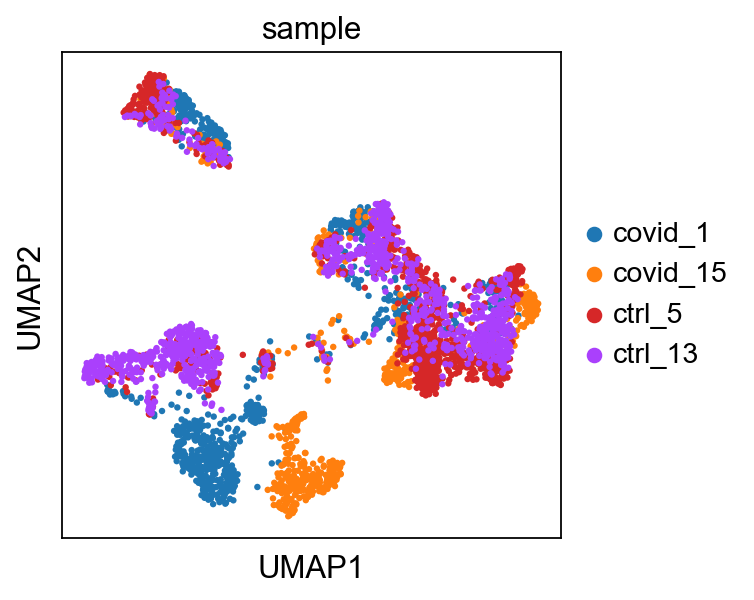

In [10]:
sc.pp.neighbors(adata_train, n_pcs = 30, n_neighbors = 20) 
sc.tl.pca(adata_train)
sc.tl.umap(adata_train)
sc.pl.umap(adata_train, color='sample')

Ingest the `adata_test`: new samples based on the `adata_train`: existing samples used as reference data to fit the UMAP reducer.

In [11]:
# sc.pp.neighbors(adata_test, n_pcs = 30, n_neighbors = 20) 
# sc.tl.umap(adata_test)

In [12]:
# add a new metadata field to adata_test with the original sample labels
#adata_test.obs['original_sample_labels'] = adata_test.obs['sample']

In [13]:
#sc.tl.ingest(adata_test, adata_train, obs='sample', embedding_method='umap')
sc.tl.ingest(adata_test, adata_train, embedding_method='umap')

running ingest
    finished (0:00:12)


/Users/koheidozono/TUM/guided_research/github/corona_single_cell_analysis/scanpy_custom/scanpy/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


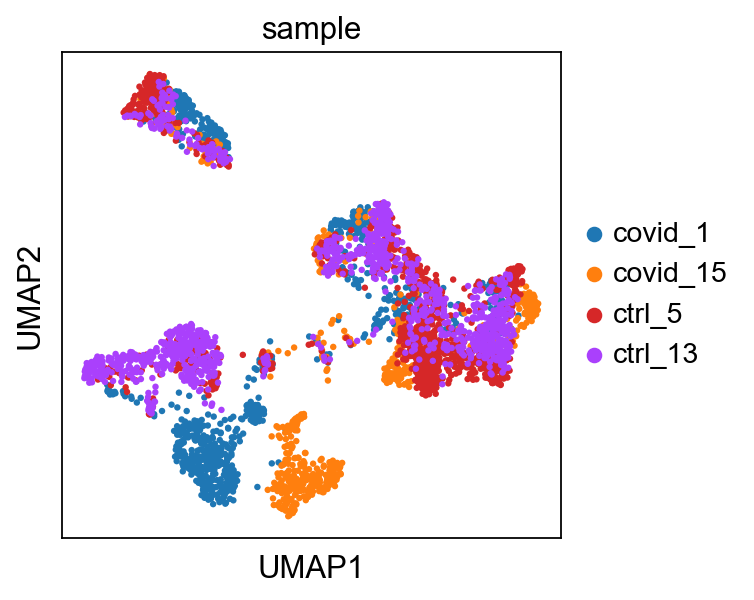

In [20]:
sc.pl.umap(adata_train, color='sample')

/Users/koheidozono/TUM/guided_research/github/corona_single_cell_analysis/scanpy_custom/scanpy/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


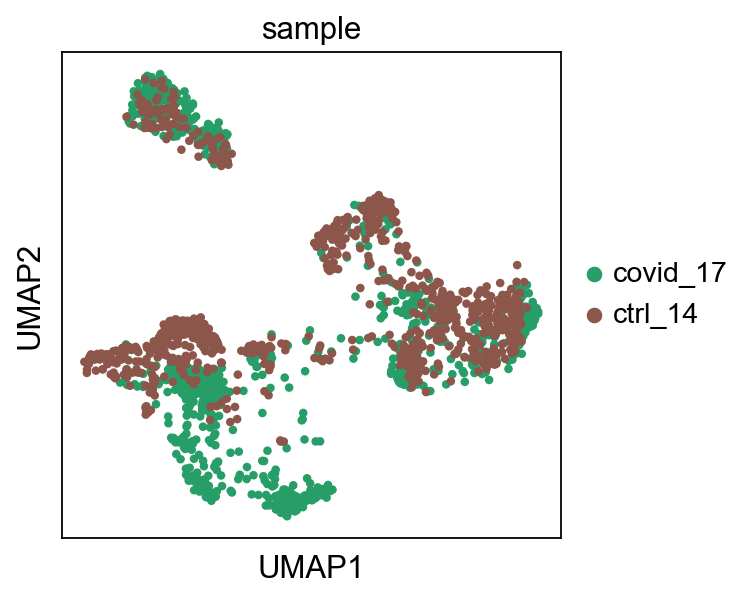

In [22]:
sc.pl.umap(adata_test, color='sample')

In [23]:
# Swap the columns of adata_test.obs['sample'] with adata_test.obs['original_sample_labels']
# And rename original_sample_labels with sample_ingested

# def sample_swap(adata):
#     adata.obs['sample_ingested'] = adata.obs['sample']
#     adata.obs['sample'] = adata.obs['original_sample_labels']
#     return adata

# sample_swap(adata_test)

In [26]:
adata_test

AnnData object with n_obs × n_vars = 2016 × 3066
    obs: 'type', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'contain_y_train', 'contain_y_test'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'doublet_info_colors', 'hvg', 'log1p', 'sample_colors', 'tsne', 'umap'
    obsm: 'X_tsne', 'rep', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [27]:
adata_concat = adata_train.concatenate(adata_test, batch_categories=['ref', 'new'])

/opt/homebrew/Caskroom/miniforge/base/envs/scanpy_tutorial/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [28]:
adata_concat.obs['sample'].unique()

array(['covid_1', 'covid_15', 'ctrl_5', 'ctrl_13', 'covid_17', 'ctrl_14'],
      dtype=object)

/Users/koheidozono/TUM/guided_research/github/corona_single_cell_analysis/scanpy_custom/scanpy/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


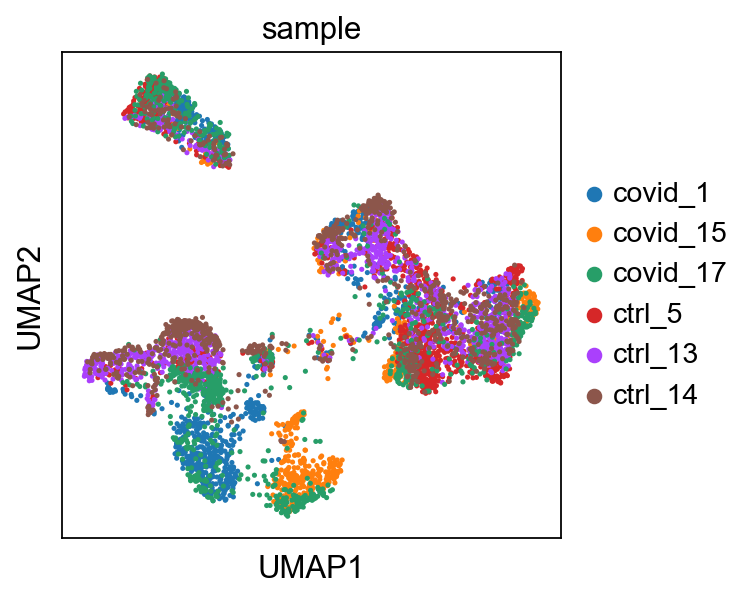

In [29]:
sc.pl.umap(adata_concat, color = 'sample')